# Modeling of GOCART dust emission (dust_opt=1) over the Middle East on 24 June 2016

In [1]:
#https://ldas.gsfc.nasa.gov/gldas/soils

from utils import *
import netCDF4 as nc
import numpy as np
from matplotlib import pyplot as plt
import os

from gocart_source_dust import gocart_source_dust
from mpl_toolkits.basemap import Basemap
from datetime import datetime

from IPython.display import display
from ipywidgets import FloatSlider
import ipywidgets as widgets

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Load required arrays from wrfoutput file
wrf_out_file = "gocart.nc"
print("Read from: "+wrf_dir + wrf_out_file)
nc_fid = nc.MFDataset(wrf_dir + wrf_out_file)
times = nc_fid.variables["Times"][:]
u10 = nc_fid.variables["U10"][:]
v10 = nc_fid.variables["V10"][:]
w10m = np.sqrt(u10 * u10 + v10 * v10)
isltyp = nc_fid.variables["ISLTYP"][:]
smois = nc_fid.variables["SMOIS"][:, 0, :]  # soil moisture of first level
erod = nc_fid.variables["EROD"][:]
airden = 1.0 / nc_fid.variables["ALT"][:, 0, :]
xland = nc_fid.variables["XLAND"][0, :]

#WRF-Chem's flux (kg/m2/sec)
wrf_chems_flux= nc_fid.variables['EDUST1'][:,0]+\
  nc_fid.variables['EDUST2'][:,0]+\
  nc_fid.variables['EDUST3'][:,0]+\
  nc_fid.variables['EDUST4'][:,0]+\
  nc_fid.variables['EDUST5'][:,0]
nc_fid.close()

Read from: ./data/gocart.nc


In [3]:
def plot_emissions(**tuning_params):
    k=len(times)
    fig, axes = plt.subplots(1, k,figsize=(k*6,6))
    for time_idx in np.arange(0, k):
        flux, u_ts, u_tres = gocart_source_dust(nx, ny, w10m[time_idx], isltyp[time_idx], smois[time_idx], erod[time_idx], airden[time_idx], xland,**tuning_params)
        #Computed flux (kg/m2/sec)
        total_emission_flux = np.sum(surface*flux) #(kg/sec)

        m = Basemap(**basemap_params,ax=axes[time_idx])
        x, y = m(xlon, xlat)
        decorateMap(m)

        date_time_obj = datetime.strptime(str(b"".join(times[time_idx])), "b'%Y-%m-%d_%H:%M:%S'")
        axes[time_idx].set_title(date_time_obj.strftime("%d %B, %H%M UTC") + "\n Instant dust flux: " + "{:0.1f}".format(total_emission_flux) + " ($kg\ sec^{-1}$)")

        cs = m.pcolormesh(x, y, flux, cmap=colmap, norm=ai_norm)

    cbar = fig.colorbar(cs,ax=axes.ravel().tolist(),orientation="horizontal",extend='max',format='%.0e')
    cbar.set_label("Instant GOCART Dust emissions, " + units)
    plt.show()

# emission flux computed by the script

In [4]:
tuning_params = {'C_factor':FloatSlider(description="C_factor",min=0.1,max=2.0,step=0.1,value=0.5,continuous_update=False)}
widgets.interact(plot_emissions,**tuning_params)

interactive(children=(FloatSlider(value=0.5, continuous_update=False, description='C_factor', max=2.0, min=0.1…

<function __main__.plot_emissions(**tuning_params)>

# emission flux computed by WRF-Chem

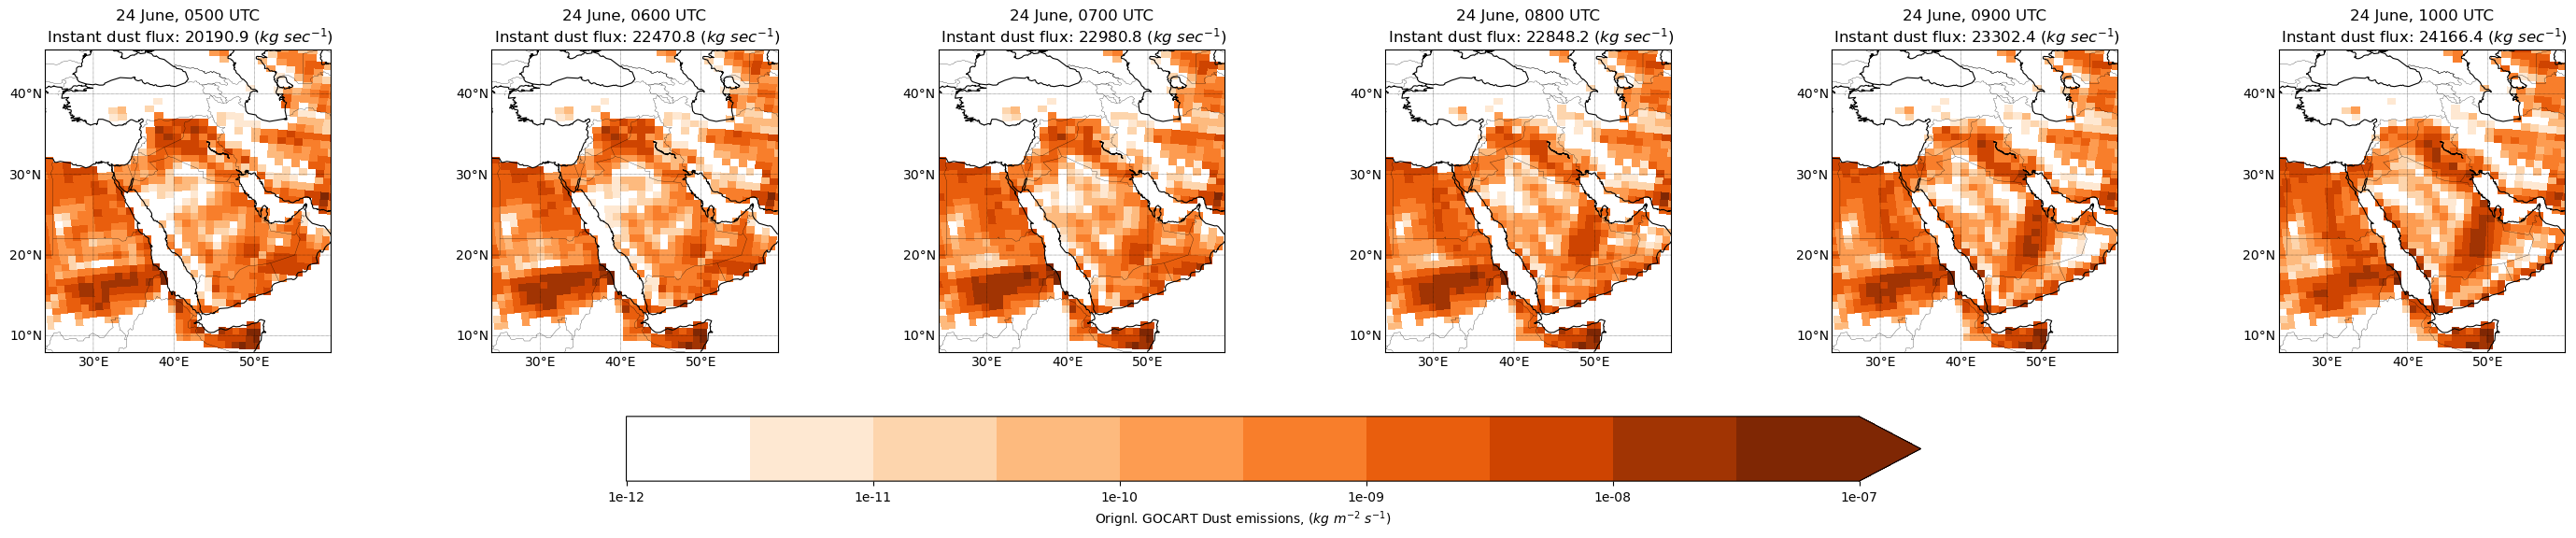

In [5]:
k=len(times)
fig, axes = plt.subplots(1, k,figsize=(k*6,6))
for time_idx in np.arange(0, k):
    #because emissions are accumulated here (cumulative, kg/m2)
    #make them average (during one hour) flux
    #flux=(emissions-prev_emissions)/3600.0 # (kg/m2/sec) it will be a little different from what calculated in gocart_python.py

    total_emission_flux=np.sum(surface*wrf_chems_flux[time_idx]) #(kg/sec)

    m = Basemap(**basemap_params,ax=axes[time_idx])
    x, y = m(xlon,xlat)
    decorateMap(m)

    date_time_obj = datetime.strptime(str(b"".join(times[time_idx])), "b'%Y-%m-%d_%H:%M:%S'")
    axes[time_idx].set_title(date_time_obj.strftime("%d %B, %H%M UTC")+"\n Instant dust flux: "+"{:0.1f}".format(total_emission_flux)+" ($kg\ sec^{-1}$)")

    cs = m.pcolormesh(x, y, wrf_chems_flux[time_idx], cmap=colmap, norm=ai_norm)


cbar = fig.colorbar(cs,ax=axes.ravel().tolist(),orientation="horizontal",extend='max',format='%.0e')
cbar.set_label('Orignl. GOCART Dust emissions, '+units)
plt.show()
#plt.savefig("gocart_orgl_inst_flux.png",bbox_inches="tight",dpi=300)